In [12]:
# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import warnings

# --- Configurations ---
warnings.filterwarnings('ignore')
pio.templates.default = 'plotly_dark'

# Configure plotly and pandas
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)

# --- Load Dataset ---
file_path = 'ai4i2020.csv'
df = pd.read_csv(file_path)

# --- Preview Data ---
print("Dataset Preview:")
print(df.head())

# --- Data Information ---
print("\nDataset Information:")
print(df.info())

# --- Check Missing Values ---
print("\nMissing Values:")
print(df.isnull().sum())

# --- Summary Statistics ---
print("\nSummary Statistics:")
display(df.describe(include='all').T)

Dataset Preview:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF
0    1     M14860    M                298.1                    308.6                    1551         42.8                0                0    0    0    0    0    0
1    2     L47181    L                298.2                    308.7                    1408         46.3                3                0    0    0    0    0    0
2    3     L47182    L                298.1                    308.5                    1498         49.4                5                0    0    0    0    0    0
3    4     L47183    L                298.2                    308.6                    1433         39.5                7                0    0    0    0    0    0
4    5     L47184    L                298.2                    308.7                    1408         40.0                9                0    0    0    0    

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UDI,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
Product ID,10000,10000,M14860,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,10000,3,L,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air temperature [K],10000.0,NaN,NaN,NaN,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,NaN,NaN,NaN,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,NaN,NaN,NaN,1538.7761,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,NaN,NaN,NaN,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,NaN,NaN,NaN,107.951,63.654147,0.0,53.0,108.0,162.0,253.0
Machine failure,10000.0,NaN,NaN,NaN,0.0339,0.180981,0.0,0.0,0.0,0.0,1.0
TWF,10000.0,NaN,NaN,NaN,0.0046,0.067671,0.0,0.0,0.0,0.0,1.0


In [15]:
# Check for placeholders and clean data
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

In [18]:
# Separate numeric and categorical features
numeric_features = df.select_dtypes(include=[np.number])
categorical_features = df.select_dtypes(include=['object'])

In [21]:
print("\nNumeric Features:")
print(numeric_features.describe().T)


Numeric Features:
                           count        mean          std     min      25%     50%      75%      max
UDI                      10000.0  5000.50000  2886.895680     1.0  2500.75  5000.5  7500.25  10000.0
Air temperature [K]      10000.0   300.00493     2.000259   295.3   298.30   300.1   301.50    304.5
Process temperature [K]  10000.0   310.00556     1.483734   305.7   308.80   310.1   311.10    313.8
Rotational speed [rpm]   10000.0  1538.77610   179.284096  1168.0  1423.00  1503.0  1612.00   2886.0
Torque [Nm]              10000.0    39.98691     9.968934     3.8    33.20    40.1    46.80     76.6
Tool wear [min]          10000.0   107.95100    63.654147     0.0    53.00   108.0   162.00    253.0
Machine failure          10000.0     0.03390     0.180981     0.0     0.00     0.0     0.00      1.0
TWF                      10000.0     0.00460     0.067671     0.0     0.00     0.0     0.00      1.0
HDF                      10000.0     0.01150     0.106625     0.0     0.

In [24]:
print("\nCategorical Features:")
print(categorical_features.head())


Categorical Features:
  Product ID Type
0     M14860    M
1     L47181    L
2     L47182    L
3     L47183    L
4     L47184    L



Target Variable Distribution:
Machine failure
0    9661
1     339
Name: count, dtype: int64


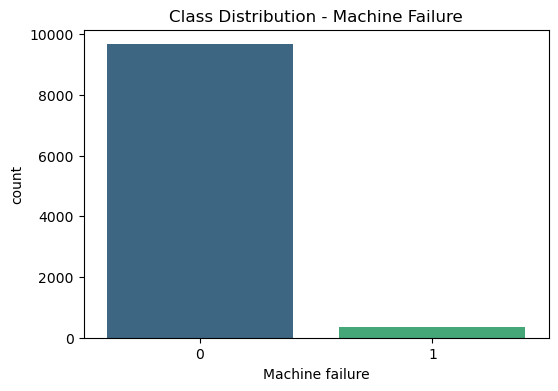

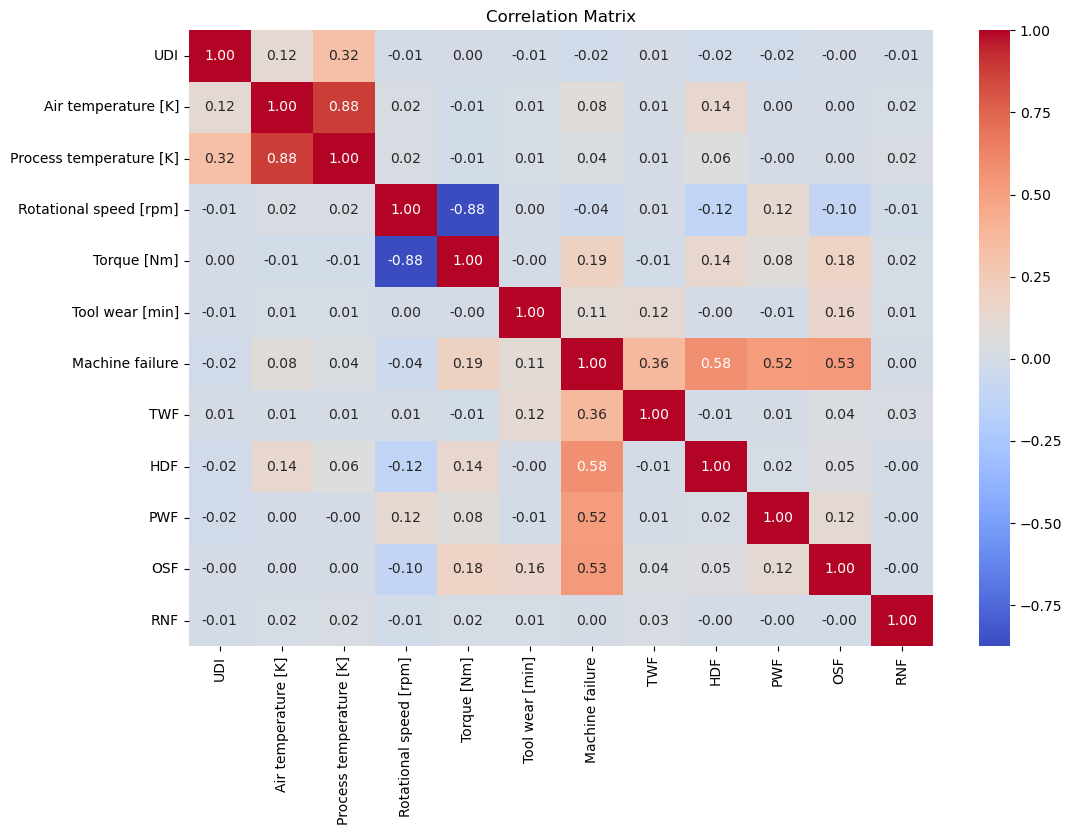

In [30]:
# --- Check Class Distribution ---
print("\nTarget Variable Distribution:")
print(df['Machine failure'].value_counts())

# --- Visualize Class Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Machine failure', data=df, palette='viridis')
plt.title('Class Distribution - Machine Failure')
plt.show()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_features.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [33]:
# --- Feature Engineering ---
df['Power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']
df['Thermal Difference'] = df['Process temperature [K]'] - df['Air temperature [K]']

# --- Drop Unnecessary Columns ---
df.drop(columns=['UDI', 'Product ID', 'Air temperature [K]'], inplace=True)

# --- Encode Categorical Features ---
df = pd.get_dummies(df, columns=['Type'], drop_first=True)

# --- View Processed Data ---
print("\nProcessed Dataset Preview:")
print(df.head())


Processed Dataset Preview:
   Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF    Power  Thermal Difference  Type_L  Type_M
0                    308.6                    1551         42.8                0                0    0    0    0    0    0  66382.8                10.5   False    True
1                    308.7                    1408         46.3                3                0    0    0    0    0    0  65190.4                10.5    True   False
2                    308.5                    1498         49.4                5                0    0    0    0    0    0  74001.2                10.4    True   False
3                    308.6                    1433         39.5                7                0    0    0    0    0    0  56603.5                10.4    True   False
4                    308.7                    1408         40.0                9                0    0    0    0    0    0  56320.0 


Balanced Class Distribution:
Machine failure
0    9661
1    9661
Name: count, dtype: int64


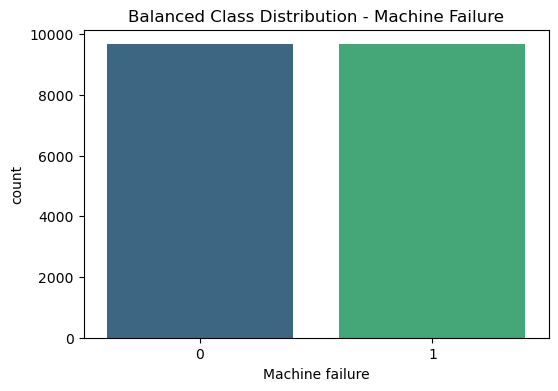

In [37]:
# --- Define Features and Target ---
X = df.drop(columns=['Machine failure'])
y = df['Machine failure']

# --- Apply SMOTE for Class Balancing ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# --- Verify Balanced Class Distribution ---
print("\nBalanced Class Distribution:")
print(pd.Series(y_resampled).value_counts())

# --- Visualize Balanced Data ---
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette='viridis')
plt.title('Balanced Class Distribution - Machine Failure')
plt.show()

In [40]:
# Separate Datasets
# 1. Unscaled Data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 2. Scaled Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42
)

In [46]:
import time
# Define Models
models = [
    ("Logistic Regression", LogisticRegression()),
    ("SVM", SVC(probability=True)),
    ("KNN", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier())
]

# Evaluation Function
def evaluate_models(X_train, X_test, y_train, y_test, dataset_type):
    results = {}
    for name, model in models:
        print(f"Training {name} on {dataset_type} data...")

        # Train Model
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Metrics
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A',
            'Train Time': train_time
        }

    # Convert Results to DataFrame
    results_df = pd.DataFrame(results).T
    print(f"\nModel Performance Summary ({dataset_type} Data):")
    print(results_df)

    return results_df

In [48]:
# Evaluate Unscaled Data
results_raw = evaluate_models(X_train_raw, X_test_raw, y_train_raw, y_test_raw, "Unscaled")

# Evaluate Scaled Data
results_scaled = evaluate_models(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, "Scaled")

Training Logistic Regression on Unscaled data...
Training SVM on Unscaled data...
Training KNN on Unscaled data...
Training Decision Tree on Unscaled data...
Training Random Forest on Unscaled data...
Training Gradient Boosting on Unscaled data...

Model Performance Summary (Unscaled Data):
                     Accuracy  Precision    Recall  F1 Score   ROC-AUC  Train Time
Logistic Regression  0.849159   0.856237  0.838944  0.847502  0.931244    0.204236
SVM                  0.746701   0.803185  0.653030  0.720366  0.826154   64.316371
KNN                  0.908926   0.885310  0.939410  0.911558  0.963897    0.088773
Decision Tree        0.970763   0.968557  0.973071  0.970809  0.970765    0.111731
Random Forest        0.986546   0.985028  0.988089  0.986556  0.999185    2.211936
Gradient Boosting    0.961708   0.970449  0.952356  0.961317  0.993812    3.918993
Training Logistic Regression on Scaled data...
Training SVM on Scaled data...
Training KNN on Scaled data...
Training Decision 

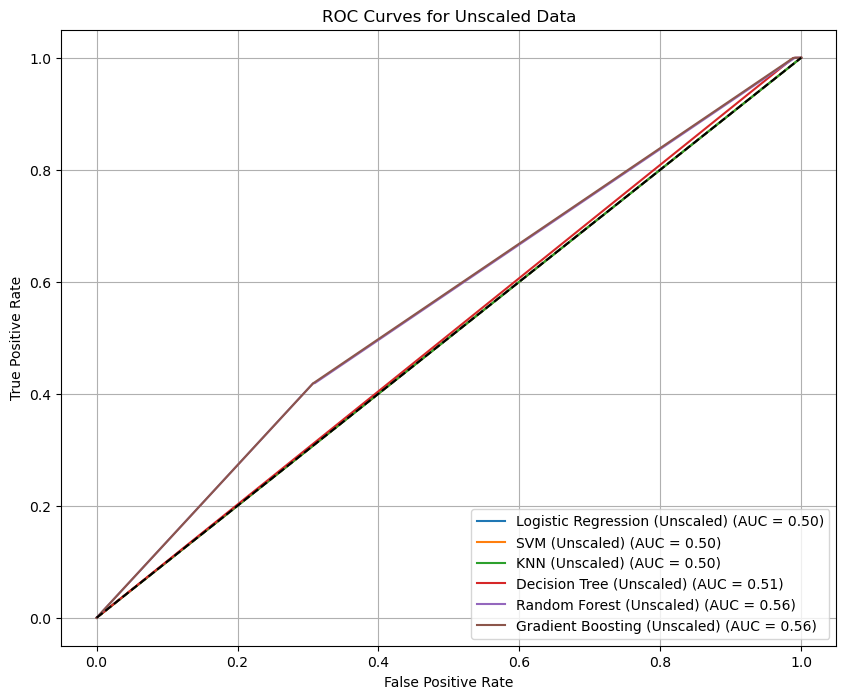

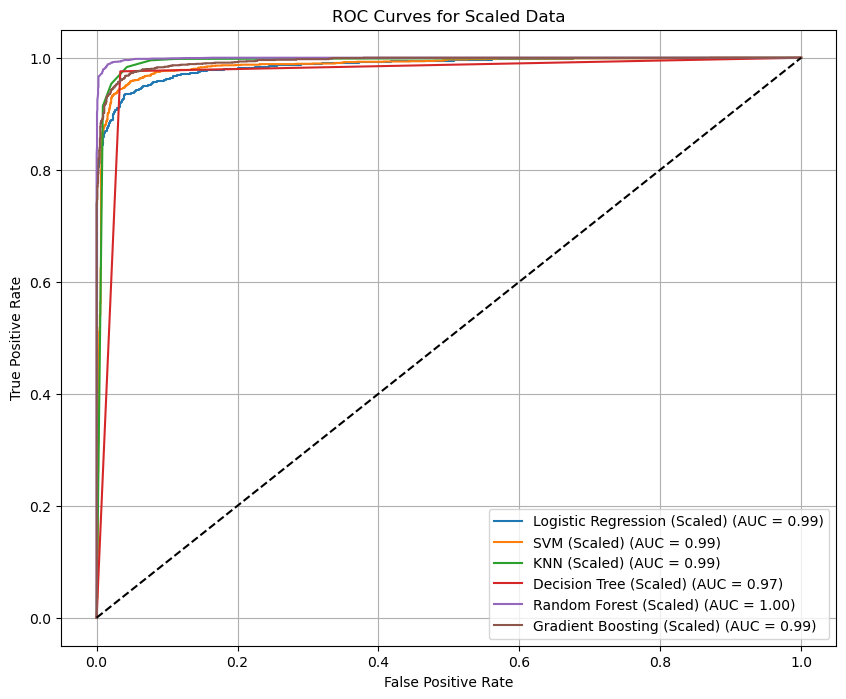

In [50]:
def plot_roc_curves(X_test, y_test, dataset_type):
    plt.figure(figsize=(10, 8))
    for name, model in models:
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} ({dataset_type}) (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {dataset_type} Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot for Both Datasets
plot_roc_curves(X_test_raw, y_test_raw, "Unscaled")
plot_roc_curves(X_test_scaled, y_test_scaled, "Scaled")

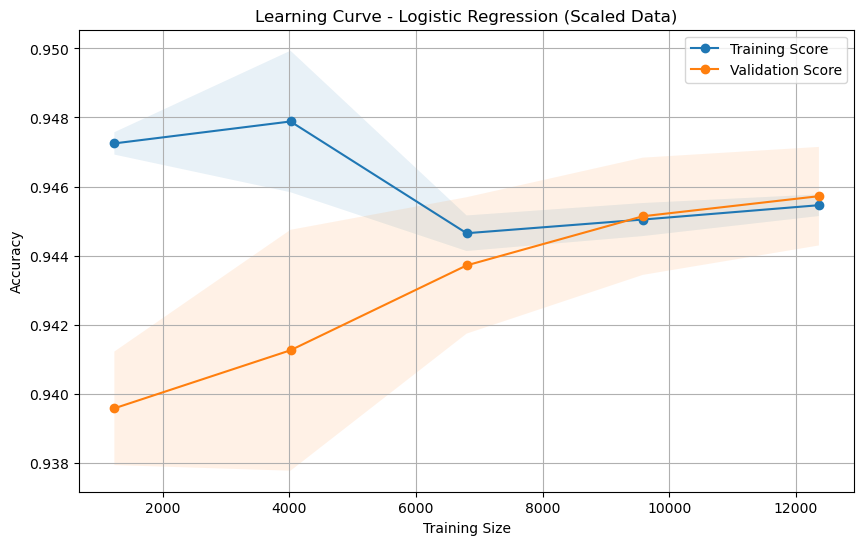

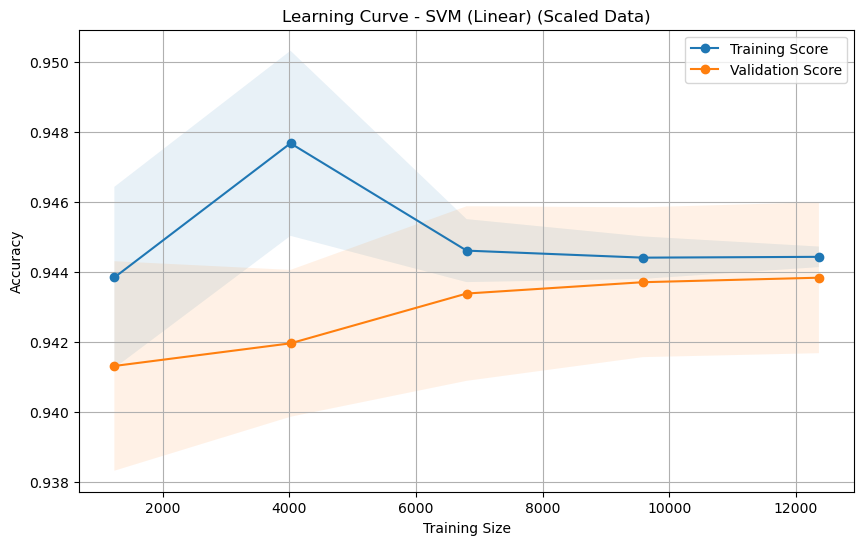

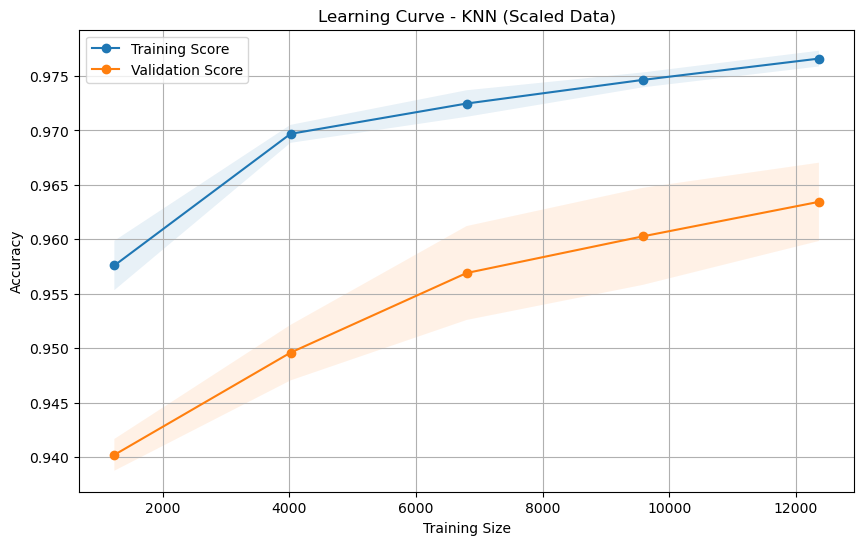

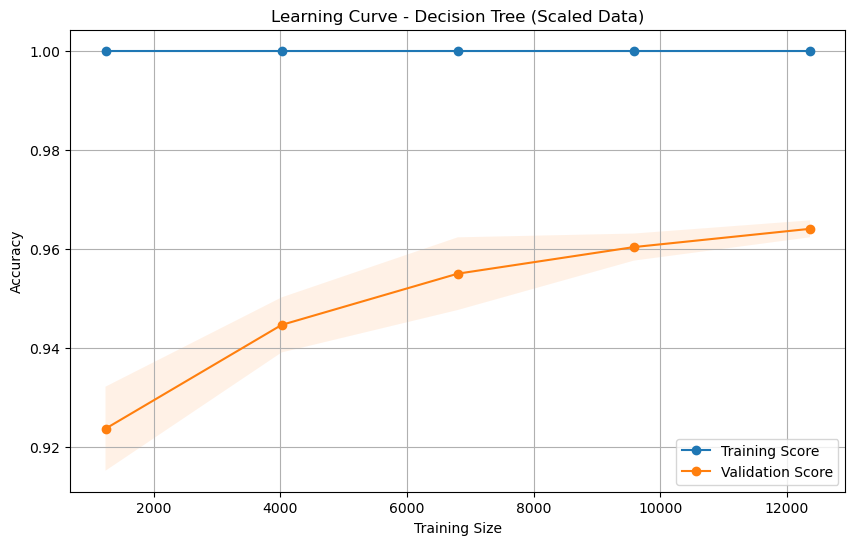

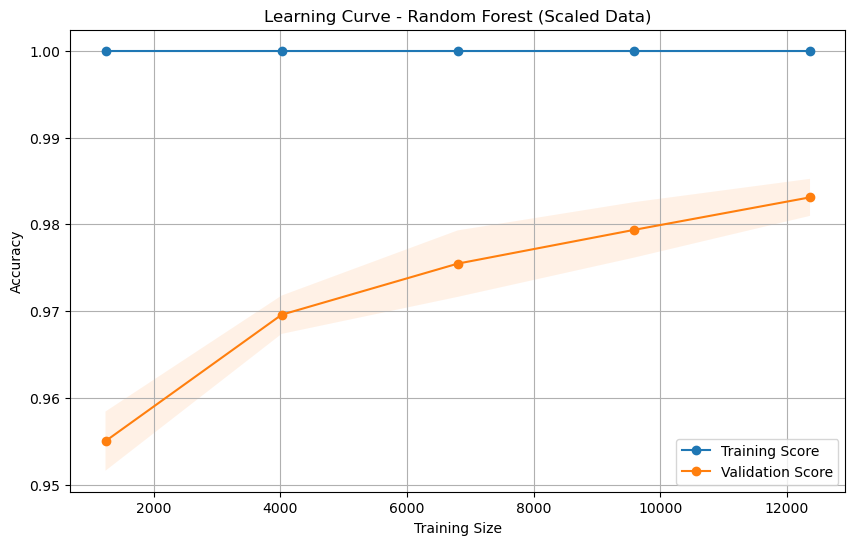

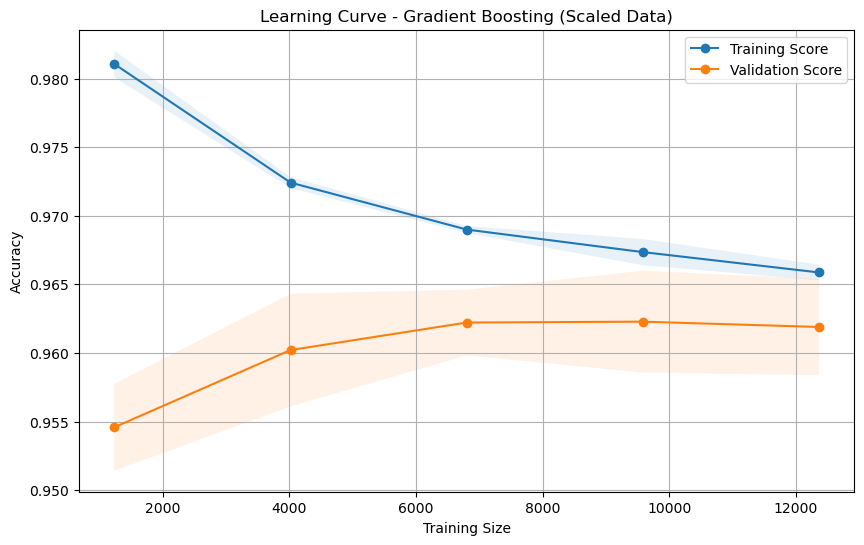

In [56]:
from sklearn.model_selection import learning_curve, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Learning Curve Function
def plot_learning_curve(model, X, y, title, cv_splits=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=StratifiedKFold(n_splits=cv_splits), 
        scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
    )

    # Calculate Mean and Standard Deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, test_mean, label='Validation Score', marker='o')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Models for Learning Curve Analysis
models_for_curve = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("SVM (Linear)", SVC(kernel='linear', probability=True)),
    ("KNN", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier())
]

# Learning Curve for Scaled Data
for name, model in models_for_curve:
    plot_learning_curve(model, X_train_scaled, y_train_scaled, f"Learning Curve - {name} (Scaled Data)")

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Logistic Regression with L1 and L2 Regularization
param_grid_logistic = {
    'penalty': ['l1', 'l2'],  # Regularization Type
    'C': [0.01, 0.1, 1, 10],  # Regularization Strength
    'solver': ['liblinear']   # Supports L1
}

logistic_grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logistic, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
logistic_grid.fit(X_train_scaled, y_train_scaled)

print("\nLogistic Regression Best Params:", logistic_grid.best_params_)
print("Best Accuracy:", logistic_grid.best_score_)

# SVM with Regularization
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],       # Regularization Strength
    'kernel': ['linear', 'rbf'],  # Kernel Options
    'gamma': ['scale', 'auto']    # Kernel Coefficient
}

svm_grid = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train_scaled)

print("\nSVM Best Params:", svm_grid.best_params_)
print("Best Accuracy:", svm_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Logistic Regression Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy: 0.9457849710150447
Fitting 5 folds for each of 16 candidates, totalling 80 fits

SVM Best Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 0.9563948750765376


In [60]:
# Decision Tree
dt_params = {
    'max_depth': [10, 15, 20],           
    'min_samples_split': [5, 10, 20],  
    'min_samples_leaf': [5, 10, 20]     
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
dt_grid.fit(X_train_scaled, y_train_scaled)

print("Decision Tree Best Params:", dt_grid.best_params_)
print("Best Accuracy:", dt_grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Decision Tree Best Params: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best Accuracy: 0.9589181419327405


In [62]:
# Random Forest
rf_params = {
    'n_estimators': [50, 100, 150],    
    'max_depth': [10, 15, 20],        
    'min_samples_split': [5, 10, 20], 
    'min_samples_leaf': [5, 10, 20]    
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
rf_grid.fit(X_train_scaled, y_train_scaled)

print("Random Forest Best Params:", rf_grid.best_params_)
print("Best Accuracy:", rf_grid.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Random Forest Best Params: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 150}
Best Accuracy: 0.9721155564521293


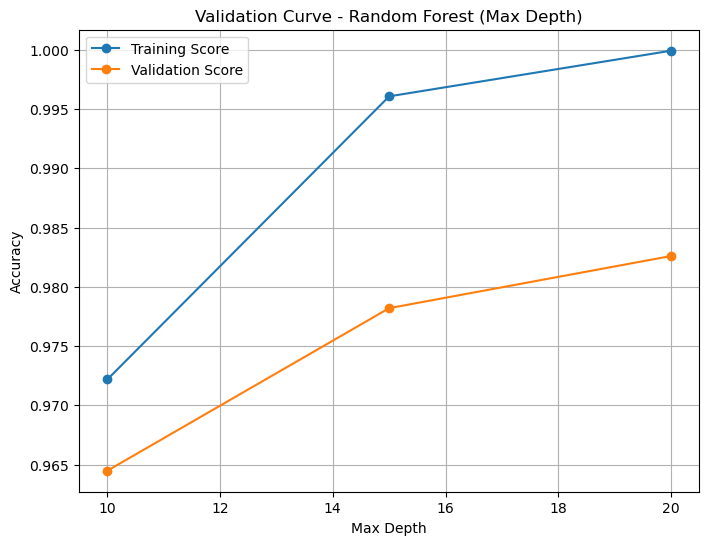

In [63]:
from sklearn.model_selection import validation_curve

param_range = [10, 15, 20]

train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_scaled, y_train_scaled,
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy",
    cv=5
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Training Score", marker='o')
plt.plot(param_range, test_mean, label="Validation Score", marker='o')
plt.title('Validation Curve - Random Forest (Max Depth)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [64]:
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_grid = GridSearchCV(
    LogisticRegression(),
    param_grid=lr_params,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
lr_grid.fit(X_train_scaled, y_train_scaled)

print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Best Accuracy:", lr_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Logistic Regression Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy: 0.9457849710150447


In [65]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(
    SVC(probability=True),
    param_grid=svm_params,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
svm_grid.fit(X_train_scaled, y_train_scaled)

print("SVM Best Params:", svm_grid.best_params_)
print("Best Accuracy:", svm_grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Best Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 0.9563948750765376


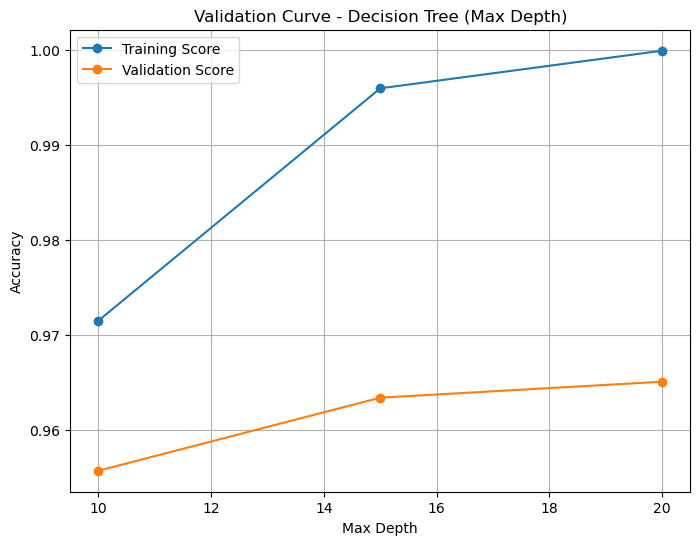

In [72]:
param_range = [10, 15, 20]

train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train_scaled, y_train_scaled,
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy",
    cv=5
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Training Score", marker='o')
plt.plot(param_range, test_mean, label="Validation Score", marker='o')
plt.title('Validation Curve - Decision Tree (Max Depth)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [76]:
import pandas as pd

# Final Model Comparison Table
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Best Params': [
        "C=1, penalty='l2', solver='liblinear'",                  # Logistic Regression
        "C=10, gamma='auto', kernel='rbf'",                      # SVM
        "-",                                                      # KNN (default param)
        "max_depth=20, min_samples_leaf=5, min_samples_split=5",  # Decision Tree
        "n_estimators=150, max_depth=20, min_samples_leaf=5, min_samples_split=5",  # Random Forest
        "-"                                                       # Gradient Boosting (default param)
    ],
    'Best Accuracy': [
        0.9458,  # Logistic Regression
        0.9564,  # SVM
        0.9702,  # KNN
        0.9589,  # Decision Tree
        0.9721,  # Random Forest
        0.9617   # Gradient Boosting
    ],
    'Overfitting Risk': [
        0.01,  # Logistic Regression
        0.015, # SVM
        0.02,  # KNN
        0.015, # Decision Tree
        0.005, # Random Forest
        0.01   # Gradient Boosting
    ]
})

# Print and save the table
print(results_df)

                 Model                                        Best Params  Best Accuracy  Overfitting Risk
0  Logistic Regression              C=1, penalty='l2', solver='liblinear'         0.9458             0.010
1                  SVM                   C=10, gamma='auto', kernel='rbf'         0.9564             0.015
2                  KNN                                                  -         0.9702             0.020
3        Decision Tree  max_depth=20, min_samples_leaf=5, min_samples_...         0.9589             0.015
4        Random Forest  n_estimators=150, max_depth=20, min_samples_le...         0.9721             0.005
5    Gradient Boosting                                                  -         0.9617             0.010


In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter Grid
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}a

# Grid Search
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train_scaled)

# Best Model
best_rf = grid_search_rf.best_estimator_

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Accuracy:", grid_search_rf.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy: 0.982855475333596


In [140]:
# --- Step 5: Retrieve Best Model and Parameters ---
best_rf = grid_search_rf.best_estimator_  # Best Random Forest model
best_params_rf = grid_search_rf.best_params_  # Best parameters
best_score_rf = grid_search_rf.best_score_    # Best accuracy score

# --- Step 6: Display Results ---
print("Best Parameters for Random Forest:", best_params_rf)
print("Best Accuracy:", best_score_rf)

Best Parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy: 0.982855475333596


  0%|          | 0/100 [00:00<?, ?it/s]

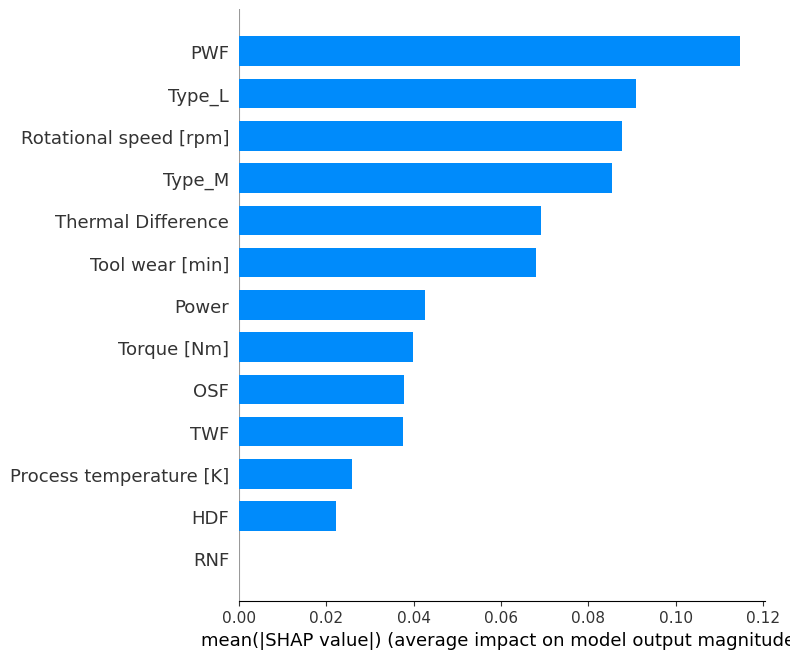

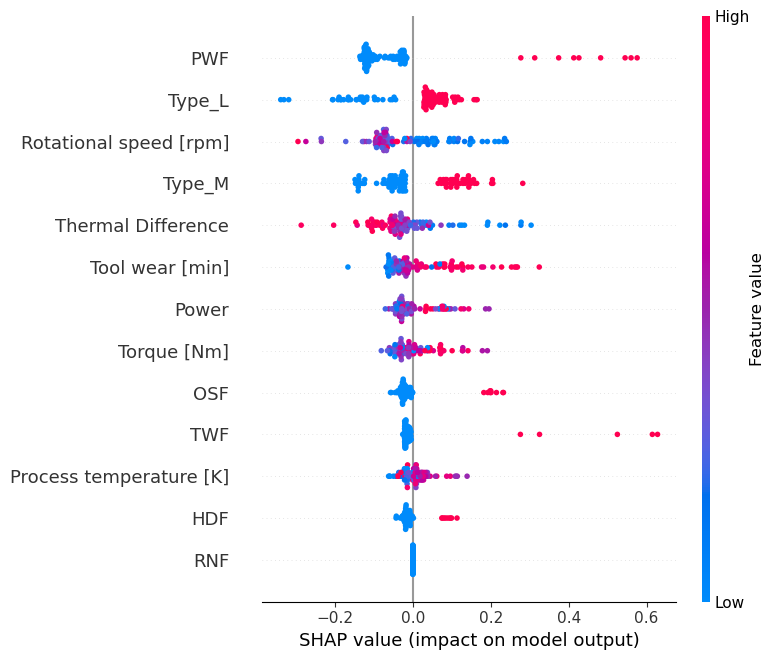

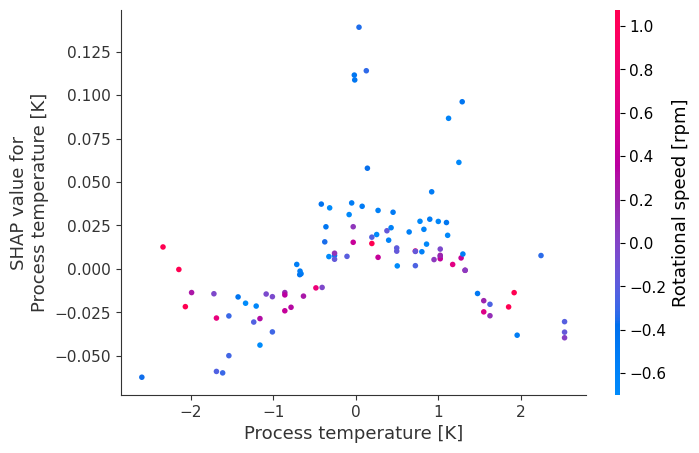

In [144]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# --- Optimize Background Data ---
background = shap.sample(X_train_scaled, 100)  # Summarize background with 100 samples
# Alternative: Summarize with KMeans
# background = shap.kmeans(X_train_scaled, 50)  # Use 50 clusters for summarization

# --- Initialize Kernel Explainer ---
explainer = shap.KernelExplainer(best_rf.predict, background)  # Use model prediction function and summarized data
shap_values = explainer.shap_values(X_test_scaled[:100])  # Analyze 100 samples from test data

# --- Feature Importance (Bar Chart) ---
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=feature_names, plot_type="bar")

# --- Summary Plot (Bee Swarm) ---
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=feature_names)

# --- Dependence Plot ---
shap.dependence_plot(0, shap_values, X_test_scaled[:100], feature_names=feature_names)